In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 26.3 MB/s eta 0:00:00


### Optunaで最適なパラメータを探す

In [3]:
import pandas as pd
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# データの読み込みと前処理
file_path = '/content/drive/My Drive/hotel_service/data/train_0111_1.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='object').columns)

# NaNの処理（カテゴリ変数は'missing'に、数値は中央値で補完）
for col in categorical_features:
    X[col] = X[col].fillna("missing").astype(str)  # CatBoost用にNaNを文字列変換
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())  # 数値変数は中央値で補完

# KFoldの設定（5分割）
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE計算の関数化
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Optunaの目的関数定義
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations',100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 8, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': 0
    }

    rmse_scores = []

    # クロスバリデーションループ
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # CatBoost用データセットの作成
        train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
        val_pool = Pool(X_val, label=y_val, cat_features=categorical_features)

        # モデルのトレーニング
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)

        # 予測とRMSE計算
        y_pred = model.predict(X_val)
        rmse = calculate_rmse(y_val, y_pred)
        rmse_scores.append(rmse)

    # クロスバリデーションの平均RMSEを返す
    return np.mean(rmse_scores)

# Optunaでハイパーパラメータ最適化の実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 最適なハイパーパラメータの表示
print("\nBest Hyperparameters:", study.best_params)
print(f"Best RMSE: {study.best_value:.4f}")


[I 2025-01-11 07:01:35,692] A new study created in memory with name: no-name-fd6a88bc-3543-4faa-9dae-069a89bc1f03
<ipython-input-3-0fff4619a839>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-0fff4619a839>:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
<ipython-input-3-0fff4619a839>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_unif


Best Hyperparameters: {'iterations': 480, 'learning_rate': 0.05124367786914214, 'depth': 9, 'l2_leaf_reg': 0.023093975477605173, 'bagging_temperature': 0.06503122464098438}
Best RMSE: 105.6652


### パラメータを指定してモデルを再トレーニングする

In [8]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import os

# データの読み込みと前処理
file_path = '/content/drive/My Drive/hotel_service/data/train_0111_1.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='object').columns)

# NaNの処理（カテゴリ変数は'missing'に、数値は中央値で補完）
for col in categorical_features:
    X[col] = X[col].fillna("missing").astype(str)  # CatBoost用にNaNを文字列変換
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())  # 数値変数は中央値で補完

# モデル保存先のディレクトリ指定
model_save_path = "/content/drive/My Drive/hotel_service/model"
os.makedirs(model_save_path, exist_ok=True)

# パラメータの設定
params = {
    'iterations': 492,
    'learning_rate': 0.04701239115088081,
    'depth': 10,
    'l2_leaf_reg': 0.6288486448764304,
    'bagging_temperature': 0.9910904178530615,
    'random_seed': 42,
    'verbose': 100
}

# K-Fold クロスバリデーションの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # CatBoostのデータ形式に変換（カテゴリ変数を明示的に指定）
    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features)

    # モデルのトレーニング
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    # 検証データでの予測とRMSE計算
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")

    # モデルの保存（正しい保存方法に修正済み）
    model_path = os.path.join(model_save_path, f"catboost_fold_{fold + 1}.cbm")
    model.save_model(model_path)
    models.append(model)
    print(f"Model saved to: {model_path}")

# クロスバリデーションの平均RMSE計算
mean_rmse = np.mean(rmse_scores)
print(f"\nMean CV RMSE: {mean_rmse:.4f}")

# 最終的なモデルの保存（すべてのデータで学習）
final_model = CatBoostRegressor(**params)
final_train_pool = Pool(X, y, cat_features=categorical_features)
final_model.fit(final_train_pool)

# 正しいモデル保存方法
final_model_path = os.path.join(model_save_path, "catboost_0111_4.cbm")
final_model.save_model(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Training fold 1
0:	learn: 165.4887141	test: 158.1207372	best: 158.1207372 (0)	total: 73.5ms	remaining: 36.1s
100:	learn: 98.0108371	test: 106.9466453	best: 106.9436333 (99)	total: 5.52s	remaining: 21.4s
200:	learn: 91.0562667	test: 106.0983419	best: 106.0983419 (200)	total: 11.3s	remaining: 16.4s
300:	learn: 84.2865563	test: 105.6614043	best: 105.6614043 (300)	total: 17.1s	remaining: 10.9s
400:	learn: 78.3114015	test: 105.4560859	best: 105.4560859 (400)	total: 23s	remaining: 5.22s
491:	learn: 74.4816184	test: 105.3437934	best: 105.3437934 (491)	total: 28.3s	remaining: 0us

bestTest = 105.3437934
bestIteration = 491

Fold 1 RMSE: 105.3438
Model saved to: /content/drive/My Drive/hotel_service/model/catboost_fold_1.cbm
Training fold 2
0:	learn: 164.0569969	test: 164.3825987	best: 164.3825987 (0)	total: 61.5ms	remaining: 30.2s
100:	learn: 98.8676620	test: 108.1754967	best: 108.1754967 (100)	total: 5.94s	remaining: 23s
200:	learn: 92.3023195	test: 106.6015427	best: 106.6015427 (200)	total: 

### モデルが重視する特徴量を可視化する

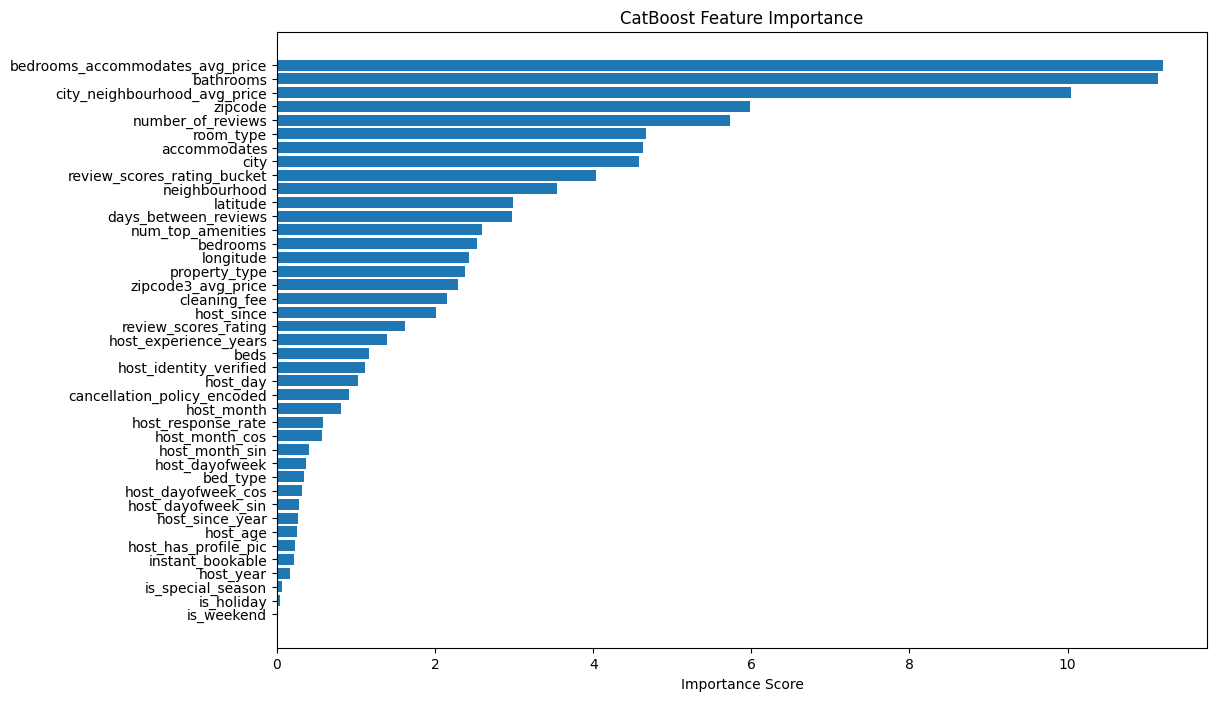

Top 10 Important Features:
                            Feature  Importance
26  bedrooms_accommodates_avg_price   11.202801
1                         bathrooms   11.143139
24     city_neighbourhood_avg_price   10.045950
19                          zipcode    5.981284
15                number_of_reviews    5.730228
18                        room_type    4.670736
0                      accommodates    4.625782
5                              city    4.575475
23      review_scores_rating_bucket    4.041291
14                    neighbourhood    3.542086
12                         latitude    2.983584
27             days_between_reviews    2.968070
20                num_top_amenities    2.595009
3                          bedrooms    2.528005
13                        longitude    2.424345
16                    property_type    2.375502
25               zipcode3_avg_price    2.283684
6                      cleaning_fee    2.150876
10                       host_since    2.007314
17           

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# ✅ 保存済みモデルのロード
cat_model_path = '/content/drive/My Drive/hotel_service/model/catboost_0111_3.cbm'
cat_model = CatBoostRegressor()
cat_model.load_model(cat_model_path)

# ✅ 特徴量名の取得
feature_names = cat_model.feature_names_

# ✅ 特徴量重要度の取得
feature_importances = cat_model.get_feature_importance()

# ✅ 特徴量重要度をデータフレームに変換
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# ✅ 特徴量重要度のプロット
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # 重要度の高い順に並べる
plt.show()

# ✅ 上位20の特徴量表示
print("Top 20 Important Features:")
print(importance_df.head(20))


### TimeSeriesSplitを適用

In [7]:
import pandas as pd
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# データの読み込みと前処理
file_path = '/content/drive/My Drive/hotel_service/data/train_0111_1.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='object').columns)

# NaNの処理（カテゴリ変数は'missing'に、数値は中央値で補完）
for col in categorical_features:
    X[col] = X[col].fillna("missing").astype(str)  # CatBoost用にNaNを文字列変換
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())  # 数値変数は中央値で補完

# ✅ TimeSeriesSplitの設定（5分割）
tscv = TimeSeriesSplit(n_splits=5)

# ✅ RMSE計算の関数化
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ✅ Optunaの目的関数定義
def objective(trial):
    # ハイパーパラメータの探索範囲
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 8, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': 0
    }

    rmse_scores = []

    # ✅ 時系列クロスバリデーションループ
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # CatBoost用データセットの作成
        train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
        val_pool = Pool(X_val, label=y_val, cat_features=categorical_features)

        # モデルのトレーニング
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)

        # 予測とRMSE計算
        y_pred = model.predict(X_val)
        rmse = calculate_rmse(y_val, y_pred)
        rmse_scores.append(rmse)

    # ✅ クロスバリデーションの平均RMSEを返す
    return np.mean(rmse_scores)

# ✅ Optunaでハイパーパラメータ最適化の実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# ✅ 最適なハイパーパラメータの表示
print("\nBest Hyperparameters:", study.best_params)
print(f"Best RMSE: {study.best_value:.4f}")


[I 2025-01-11 09:31:21,395] A new study created in memory with name: no-name-7b4d71c0-c956-49db-9450-d86c1a31ce1f
<ipython-input-7-446e24c28c5f>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-7-446e24c28c5f>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
<ipython-input-7-446e24c28c5f>:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_unif


Best Hyperparameters: {'iterations': 492, 'learning_rate': 0.04701239115088081, 'depth': 10, 'l2_leaf_reg': 0.6288486448764304, 'bagging_temperature': 0.9910904178530615}
Best RMSE: 106.7836
